**Question: Are there differences in environmental exposure among patients with early-onset vs late-onset Asthma?**
* Find patients diagnosed with Asthma
* Find age of diagnosis for Asthma patients
* Find location for Asthma patients
* Find exposures by location for Asthma patients
* Compare exposures of patients diagnosed with Asthma during childhood vs during adulthood

**Data Sources**
* HUSH+ synthetic data resource
* [FHIR synthetic data resource](http://ictrweb.johnshopkins.edu/ictr/synthetic/)
* [UMLS](https://www.nlm.nih.gov/research/umls/), NOTE: there is a Web API [here](https://documentation.uts.nlm.nih.gov/rest/home.html) 
* [OHDSI Web API](http://www.ohdsi.org/web/wiki/doku.php?id=documentation:software:webapi)
* [Open AQ Platform API](https://docs.openaq.org), An API for open air quality data (pm25)
* [Green Translator Exposures API](https://exposures.renci.org/v1/ui), An API for pm25 and o3 measures

### Function and dataset definitions

In [2]:
## All the imports we need
import urllib2
from urllib2 import Request, urlopen, URLError
from urllib import quote_plus

import mysql.connector

import pprint, json, requests

from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
from greentranslator.api import GreenTranslator
query = GreenTranslator ().get_query ()

import dateutil

import zipcode

import string

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
#connect to UMLS
try:
    cnx = mysql.connector.connect(user='tadmin',
                                password='ncats_translator!',
                                database='umls',
                                host='translator.ceyknq0yekb3.us-east-1.rds.amazonaws.com')
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    print
    #cnx.close()

#### UMLS and OHDSI functions

In [4]:
## Given disease/condition term, get back ICD codes from OHDSI
def findICD_ohdsi(txt, icd_version = 9):
    if icd_version == 9:
        icd_type = 'ICD9CM'
    elif icd_version == 10:
        icd_type = 'ICD10'
    else: raise Exception("Invalid ICD version specified")    
    url_con = "http://api.ohdsi.org/WebAPI/vocabulary/search"
    headers = {'content-type': 'application/json'}
    params = {"QUERY": txt,
              "VOCABULARY_ID": [icd_type]}
    response = requests.post(url_con, data=json.dumps(params), headers=headers)
    data= json.loads(response.text.decode('utf-8'))
    return [d["CONCEPT_CODE"] for d in data]
print findICD_ohdsi('asthma')

# Get ICD10/ICD9 code for a given string from UMLS. By default we get back ICD10.
def findICD_umls(name, icd_version = 10):
    if icd_version == 9:
        icd_type = 'ICD9CM'
    elif icd_version == 10:
        icd_type = 'ICD10'
    else: raise Exception("Invalid ICD version specified")

    cursor = cnx.cursor()
    query = ("SELECT CUI FROM umls.MRCONSO WHERE STR='"+name+"'")
    cursor.execute(query, ())
    res = "Undef"
    for code in cursor:
        if res=="Undef":
            res = code
    if res != "Undef":
        query = ("SELECT CODE FROM umls.MRCONSO WHERE SAB='"+icd_type+"' AND CUI='"+res[0]+"'")
        cursor.execute(query, ())
        icd10 = "Undef"
        for code in cursor:
            icd10 = code
        return (icd10[0])
    return ("Undef")

[u'E945.7', u'493', u'493.9', u'493.90', u'493.92', u'493.91', u'493.2', u'493.20', u'493.22', u'493.21', u'493.82', u'493.0', u'493.00', u'493.02', u'493.01', u'V17.5', u'493.1', u'493.10', u'493.12', u'493.11', u'493.8', u'975.7']


#### Exposure data source founctions

In [5]:
#Function takes date of diagnosis, and location as input and returns degree of exposure 

def findExposureAtDateOfDx(dxdate,lon,lat):
    #dxnextdate = dateutil.parser.parse(dxdate) + timedelta(days=1)
    #dxnextdate = datetime.date(dxnextdate)
    pm25score = query.expo_get_scores (exposure_type = 'pm25',
                            start_date = dxdate,
                            end_date = dxdate,
                            exposure_point = ''+lon+','+lat+'')
    return(pm25score) 

def findAirQualityAtDateOfDx(dxdate,lat,lon):
    try:
        url = "https://api.openaq.org/v1/measurements?coordinates="+lat+','+lon+"&date="+dxdate+"&parameter=pm25"
        txt = urlopen(url).read()
    except Exception, e:
        raise Exception(e)
    exps= json.loads(txt)
    pprint.pprint(exps)
    return(exps)

#### HUSH+ and FHIR synthetic data source functions

In [6]:
## Functions to retreive patients from different sources - HUSH+ & FHIR synthetic
def findPatients_fhir(code):
    try:
        url ="http://ictrweb.johnshopkins.edu/rest/synthetic/Condition?icd_10="+code+"&_count=%d"
        txt = urlopen(url).read()
    except Exception, e:
        raise Exception(e)
    stuff = json.loads(txt)
    #print stuff
    return(stuff)

def findPatients_unc(age='8', sex='male', race='white', location='OUTPATIENT'):
    query = GreenTranslator ().get_query()
    return query.clinical_get_patients(age, sex, race, location)

In [7]:
#Function to retrieve age at diagnosis & location for patients from FHIR synthetic
def findDxAgeLocation_fhir(stuff):
    #pprint.pprint(stuff)
    res = []
    if stuff==[]:
        return []
    for p in stuff['entry']:
        #pprint.pprint(p)
        d1 = p['assertedDate']
        id = p['subject']['reference'][8:]
        try:
            url = 'http://ictrweb.johnshopkins.edu/rest/synthetic/Patient/'+id
            txt = urlopen(url).read()
        except:
            print "ictr api doesn't work"
        st = json.loads(txt)
        #pprint.pprint(st)
        d2 = st['birthDate']
        z = st['address'][0]['postalCode']
        datedx = d2 #e.g. 1925-12-08 00:00:00
        d1 = dateutil.parser.parse(d1)
        d2 = dateutil.parser.parse(d2)
        #print d1
        #print d2
        diff = d1 - d2
        #print diff
             
        obj = zipcode.isequal(z.encode("ascii", "ignore"))
        if obj is not None:
            d = obj.to_dict()
            lat = d['lat']
            lon = d['lon']
        else:
            lat = None
            lon = None
        t = (id,diff.days,datedx,lat,lon)         
        res.append(t)
    return(res)

#Add function to retrieve age at diagnosis & location for patients from HUSH+

### "What is the age range of Asthma diagnoses, grouped by location?"

count       50.000000
mean      9361.000000
std       6447.721958
min        958.000000
25%       4202.750000
50%       8018.000000
75%      13403.500000
max      26061.000000
Name: ageOfDxInDays, dtype: float64
count       50.000000
mean      9361.000000
std       6447.721958
min        958.000000
25%       4202.750000
50%       8018.000000
75%      13403.500000
max      26061.000000
Name: ageOfDxInDays, dtype: float64
count       50.000000
mean      9361.000000
std       6447.721958
min        958.000000
25%       4202.750000
50%       8018.000000
75%      13403.500000
max      26061.000000
Name: ageOfDxInDays, dtype: float64
count       50.000000
mean      9361.000000
std       6447.721958
min        958.000000
25%       4202.750000
50%       8018.000000
75%      13403.500000
max      26061.000000
Name: ageOfDxInDays, dtype: float64
count       50.000000
mean      9361.000000
std       6447.721958
min        958.000000
25%       4202.750000
50%       8018.000000
75%      13403.50000

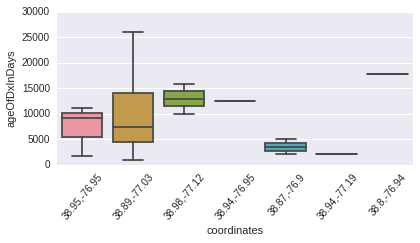

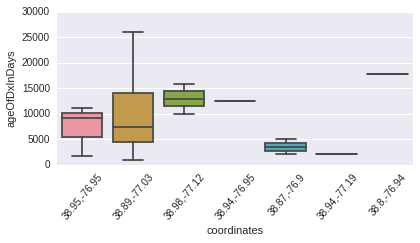

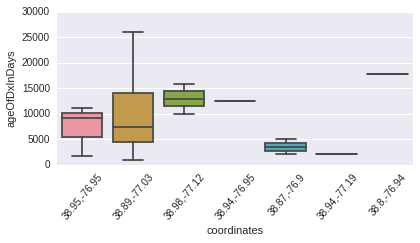

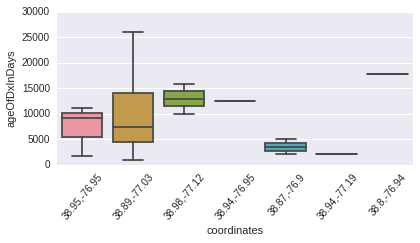

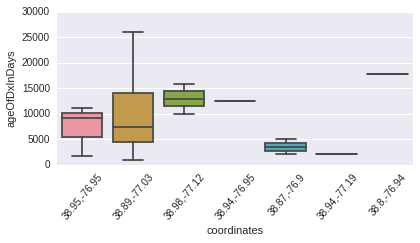

In [8]:
asthmaCodes = findICD_umls("asthma") # We go with ICD10 codes

## Get age of diagnosis & locations for FHIR synthetic patients.
p_agelocs = []
for icd in asthmaCodes:
    try:
        p = findPatients_fhir(icd)
        # patients with icd exist
    except:
        print "no patients with icd"
        exit()
    p_ageloc = findDxAgeLocation_fhir(p)
    #pprint.pprint(p_ageloc)
    
    for dx in p_ageloc:
        num = int(dx[0])
        ageOfDxInDays = int(dx[1])
        dateAtDx = str(dx[2])
        lat = dx[3]
        lon = dx[4]
        coordinates=''+str(lat)+','+str(lon)+''
        #print coordinates
        p_agelocs.append((num, ageOfDxInDays,dateAtDx,lat,lon,coordinates))
        #p_agelocs.append(dx)
    #print p_agelocs[1]
    p_agelocs_df = pd.DataFrame(p_agelocs, columns=['id', 'ageOfDxInDays', 'dateAtDx', 'lat', 'lon','coordinates'])
    #print  p_agelocs_df
    
    s = p_agelocs_df['ageOfDxInDays']
    print s.describe()
    
    g = sns.factorplot(x="coordinates", y="ageOfDxInDays", data=p_agelocs_df, kind="box", size=3, aspect=2)
    g.set_xticklabels(rotation=50)


## Add code to get age of diagnosis & locations for HUSH+ patients.

### "What is the age range of Asthma diagnoses, grouped by air quality threshold?"
NOTE: will need to find literature-based thresholds for high & low air quality

In [9]:
##For date of diagnosis and location, what is air quality (pm25)?

#findExposureAtDateOfDx("2010-01-07","35.9131996","-79.0558445")
#findAirQualityAtDateOfDx("2010-01-07","35.91","-79.05")

for item, p in p_agelocs_df.iterrows():
    dateDx = p['dateAtDx']
    lat = p['lat']
    lon = p['lon']
    print dateDx
    print lat
    txt =''
    try:
        txt = findAirQualityAtDateOfDx(dateDx,lat,lon)
        #findExposureAtDateOfDx(dateDx,lon,lat)
    except:
        print "location not found"
        #exit()
    if len(txt)> 0:
        p_exp = json.loads(txt)
    else:
        p_exp = []
    #pm25 = p_exp['value']
    #print pm25


1982-06-05
38.95
location not found
1978-06-16
38.89
location not found
1958-05-31
38.89
location not found
1965-05-20
38.89
location not found
1954-02-06
38.89
location not found
1942-09-11
38.89
location not found
1955-01-31
38.89
location not found
1922-01-24
38.89
location not found
1952-01-12
38.98
location not found
1941-12-26
38.89
location not found
1967-09-26
38.89
location not found
1988-10-18
38.89
location not found
1961-02-08
38.94
location not found
1965-03-01
38.89
location not found
1955-01-25
38.89
location not found
1969-12-01
38.89
location not found
1991-03-13
38.89
location not found
1953-10-19
38.89
location not found
1943-03-16
38.89
location not found
1986-03-11
38.87
location not found
1997-04-24
38.89
location not found
1971-03-27
38.89
location not found
1952-11-05
38.89
location not found
2005-09-19
38.87
location not found
1996-02-15
38.94
location not found
1981-05-25
38.89
location not found
1973-08-27
38.89
location not found
1936-02-20
38.89
location no